# Which Countries of the World are Concerned about Climate?

#### <p style="font-family: Arial; font-size:1.4em;color:green;">  This is the companion code for my article on <a href="https://medium.com/@dyaus/mining-bittorrent-which-countries-are-concerned-about-climate-change-5114edd7aeb5"><font color='blue'>Medium</font></a>. If you find any issues, bugs or abysmal flaws, <a href="https://twitter.com/deepakKarunakrn"><font color='red'>shout out</font></a>, either on the Medium platform or here.</p>
<img src="./data/climate-change-analysis/pexels-nick-bondarev-4310199.jpg" width="800" height="400">


## Importing another notebook

### Another notebook [torrent-peers-geolocation-finder](./torrent-peers-geolocation-finder.ipynb) consists of code required for this analysis. Sp running that code and using the methods here.

In [2]:
import io
import nbformat

## The following code executes the notebook so that the functions and variables could be accessed here.
##Input: Path to notebook file
## Output: None

def run_notebook(notebook_file):
    with io.open(notebook_file, encoding="utf8") as f:
        nb = nbformat.read(f, as_version=4)

    ip = get_ipython()

    for cell in nb.cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.source)

In [ ]:
### Executing the notebook torrent-peers-geolocation-finder.npyb
run_notebook('./torrent-peers-geolocation-finder.ipynb')

## Processing the Environment Documentary/Movie Torrents

In [ ]:
### This function takes in the torrent infohash file and constructs a nested dictionary with natural numbers as key in
### the top level and for the next level,
### torrent filename as the key and the tuple of (list of peer IPs, list of countries, list of cities) as the value.

### Input: Path to torrent infohas file which is of the format below:
## Example file content:
## torrent-infohash.txt
# ---Filename1
# FE0A480DA7982AC1B98D7E0F095B05DF38AF2E82
# 6E7DD9374CECA1F189CC1431C66BA3C37918B603
# 195FE6211E3CD4DFEFB4466D41C0689BB26EE8E3 
# F97634037E25A368AE72AC02775A901CB860163F
# ---Filename2
# AAA850BAEEE1DDFBE373B83F6E53D65BEF98A2FE
# D882F0809D3E4DC3034502C3E00023B4F255EAB4
# ECC810501C8BEF6C1E0E2A27F1069858199EEB2A 

### Output: A Nested Dictionary
## Example: {
#            0:{
#               Filename1:[list of countries]
#             },
#           1:{
#              Filename2:[list of countries]
#             }
#           }


def countries_dict(torrent_infohash_file_path):    
     
    # the dictionary variable
    dict_0 = {}
    
    # reading the file and processing it        
    with open(torrent_infohash_file_path,'r') as file:
        content = file.read()       
         
        # separating the infohash lists for each file
        _infohash_lists = content.split('---')[1:]
        
        #dictionary for a particular torrent
        dict_1 = {}
        id = 0
        
        #looping through infohash and building the dictionaries
        for _list in _infohash_lists:            
                 
            _key =  _list.split('\n')[0]
            _infohashes = _list.split('\n')[1:-1] 
            _peers_list = []
            for i in range(0,2):     
                    _peers_list = extract_peers_from_network(_infohashes) 
                    
            dict_1[_key] = (_peers_list,findCountriesList(_peers_list),findCitiesList(_peers_list))
            print("Extracted peers for:"+ _key)
            
            #adding the dictionary to root
            dict_0[id] = dict_1
            
            id += 1
            
    return dict_0

In [ ]:
## Building the dictionary for torrents using the function

path = ".\\data\\climate-change-analysis\\"
file = 'random_movies_torrents_list.txt'
dict_movies = countries_dict(path + file)
file = 'environment_torrent_list.txt'
dict_environment = countries_dict(path + file)

### Storing the output for reuse  

In [ ]:
import pickle 
path = ".\\data\\climate-change-analysis\\"
with open(path+"dict_environment.dat","wb") as f:
    pickle.dump(dict_environment,f)
with open(path+"dict_movies.dat","wb") as f:
    pickle.dump(dict_movies,f)


# Analytics

### Reading the data into variables

In [4]:
import pickle
path = ".\\data\\climate-change-analysis\\"
with open(path+"dict_environment.dat","rb") as f:
    dict_environment = pickle.load(f)
with open(path+"dict_movies.dat","rb") as f:
    dict_movies = pickle.load(f)

## Generating Data Points

In [3]:
## The objective is to create a feature vector for each torrent file. So if Chasing Coral is a documentary and it has peers
## as follows : Australia-2, India-20, US- 40 then assuming there are only 3 countries in the world the vector would be 
## [2,20,40]

## So if there are N countries then the feature length would be N and #peers in each country for a torrent would be an element
# So first we find the list of all countries combined across all torrents files of interest.

###The following function accomplishes the objective
##Input: Dictionary contructed above. List of countries in the whole dataset
##Output: Dataframe of feature vectors

import pandas as pd

def constructDataFrame(dictionary,allCountries):    

    #creating frequency vectors and appending to list
    FeatureVectors = []
    keys = dictionary[0].keys()
    for key in keys: 
        peers_list,cntry_list,cities_list = dictionary[0][key]
        feature=[]
        for cntry in allCountries:         
            feature.append(cntry_list.count(cntry))

        FeatureVectors.append(feature)

    #creating a  dataframe
    df  = pd.DataFrame(FeatureVectors,columns = allCountries)
    return df 

In [2]:
## This function constructs the set of all the countries from where there is at least one peer, across all torrents.
## The output from this fucntion is used as input for constructing Pandas dataframes using constructDataFrame() defined 
## above.

#Input: List of Dictionaries generated using countries_dict()
#Outut: List of unique countries.

def setOfAllCountries(listOfDictionaries):
    
    allCountries = []
    
    for d in listOfDictionaries:
        for key in d[0].keys(): 
            peers,countries,cities = d[0][key]
            allCountries+=countries   
    

    #removing duplicates  and sorting
    allCountries = [*{*allCountries}]  
    allCountries.sort()
    
    return allCountries

### Executing the functions to create dataframes

In [9]:
listofAllCountries = setOfAllCountries([dict_environment,dict_movies])
df_env = constructDataFrame(dict_environment,listofAllCountries)
df_mov = constructDataFrame(dict_movies,listofAllCountries)

## Filtering countries out which have less than N (=10) peers summed across env. torrents

In [10]:
 
#finding column sums
column_sums = df_env.sum(axis=0)
column_sums = list(column_sums)

#removing countries with less than 10 peers
boolean_column = [(x>10) for x in column_sums]
country_list = list(df_env.columns)
 
df_env = df_env.loc[:,boolean_column]
df_mov = df_mov.loc[:,boolean_column]

## Only 31 countries remain
df_env 

,Argentina,Australia,Bangladesh,Brazil,Bulgaria,Canada,Chile,China,Croatia,Greece,...,Poland,Romania,Serbia,South Africa,Spain,Sri Lanka,Sweden,Switzerland,United Kingdom,United States
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,11,0,2,0,0,0,5
2,0,2,1,2,0,1,0,1,2,0,...,0,4,1,1,1,3,0,1,0,8
3,0,7,4,4,0,8,0,0,1,1,...,0,4,0,22,2,6,1,0,10,20
4,0,1,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2
5,0,2,0,0,0,3,0,0,0,0,...,0,1,1,1,2,0,10,2,0,8
6,1,5,10,1,0,4,0,2,0,1,...,0,0,0,0,0,0,0,1,0,4
7,0,0,0,1,0,4,0,1,0,0,...,0,0,0,0,1,0,0,0,0,7
8,0,1,6,3,0,1,2,2,2,2,...,0,3,0,7,2,0,0,1,0,11
9,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df_env.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Argentina,0,0,0,0,0,0,1,0,0,0,1,0,0,12,2
Australia,2,0,2,7,1,2,5,0,1,2,1,0,1,11,1
Bangladesh,0,0,1,4,0,0,10,0,6,0,5,0,0,3,0
Brazil,0,0,2,4,0,0,1,1,3,0,2,0,0,43,5
Bulgaria,0,0,0,0,1,0,0,0,0,0,0,0,0,16,2
Canada,0,1,1,8,1,3,4,4,1,0,1,0,2,7,2
Chile,0,0,0,0,0,0,0,0,2,0,0,0,1,7,1
China,0,0,1,0,0,0,2,1,2,0,0,0,3,9,0
Croatia,0,0,2,1,0,0,0,0,2,0,0,0,0,9,0
Greece,0,0,0,1,0,0,1,0,2,0,1,0,0,7,0


## Normalization

In [12]:
## Individually normalizing the feature in the two dataframes
df_env=df_env.div(df_env.sum(axis=0), axis=1)
df_mov=df_mov.div(df_mov.sum(axis=0), axis=1)
## Normalizing from the other axis
df_env=df_env.div(df_env.sum(axis=1), axis=0)
df_mov=df_mov.div(df_mov.sum(axis=1), axis=0)



In [13]:
#### This code is redundant now

## Tranposing the dataframes
#df_env_t = df_env.T
#df_mov_t = df_mov.T
## Normalizing from the other axis
#df_env=df_env_t.div(df_env_t.sum(axis=0), axis=1)
#df_mov=df_mov_t.div(df_mov_t.sum(axis=0), axis=1) 

In [14]:
## Replacing NaN with zeros 
df_env = df_env.fillna(0)
df_mov = df_mov.fillna(0)

In [15]:
df_mov=df_mov.T
df_env=df_env.T

## Finding ratio between sum of normalized peer count of climate change documentaries and movies

In [16]:
##Looking at the heads of dataframes
df_env.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Argentina,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.042894,0.000000,0.000000,0.000000,0.042701,0.0,0.000000,0.064026,0.061935
Australia,0.209305,0.0,0.026249,0.041929,0.147136,0.030171,0.095320,0.000000,0.008396,0.561163,0.018978,0.0,0.028887,0.026085,0.013763
Bangladesh,0.000000,0.0,0.016292,0.029743,0.000000,0.000000,0.236656,0.000000,0.062538,0.000000,0.117796,0.0,0.000000,0.008831,0.000000
Brazil,0.000000,0.0,0.015491,0.014140,0.000000,0.000000,0.011251,0.047586,0.014866,0.000000,0.022401,0.0,0.000000,0.060177,0.040613
Bulgaria,0.000000,0.0,0.000000,0.000000,0.278784,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.071888,0.052156


In [17]:
df_mov.head()

,0,1,2,3,4,5,6,7,8,9
Argentina,0.016800,0.029010,0.022356,0.006812,0.013513,0.040071,0.073934,0.065867,0.035909,0.015211
Australia,0.019331,0.018777,0.030318,0.027434,0.034986,0.065322,0.033422,0.021655,0.026563,0.028443
Bangladesh,0.043495,0.033381,0.022968,0.052908,0.033043,0.016651,0.015192,0.037896,0.044271,0.037194
Brazil,0.044469,0.026877,0.055795,0.010819,0.046501,0.016500,0.026094,0.049815,0.043453,0.012079
Bulgaria,0.000000,0.012692,0.167667,0.005960,0.000000,0.007792,0.006161,0.000000,0.017955,0.000000


In [18]:
row_sums_env = df_env.sum(axis=1)
row_sums_mov = df_mov.sum(axis=1)

In [19]:
quantified_concern = row_sums_env/row_sums_mov
quantified_concern.head()



Argentina     0.662183
Australia     3.942470
Bangladesh    1.400172
Brazil        0.681476
Bulgaria      1.845916
dtype: float64

### Storing the output

In [20]:
import pickle
path = ".\\data\\climate-change-analysis\\"
with open(path+"quantified_concern_values.dat","wb") as f:
    pickle.dump(quantified_concern,f)

# Visualization

## Generating barplots and choropleths to visualize the data.

#### Loading the data

In [21]:
import pickle
path = ".\\data\\climate-change-analysis\\"
with open(path+"quantified_concern_values.dat","rb") as f:
    quantified_concern = pickle.load(f)

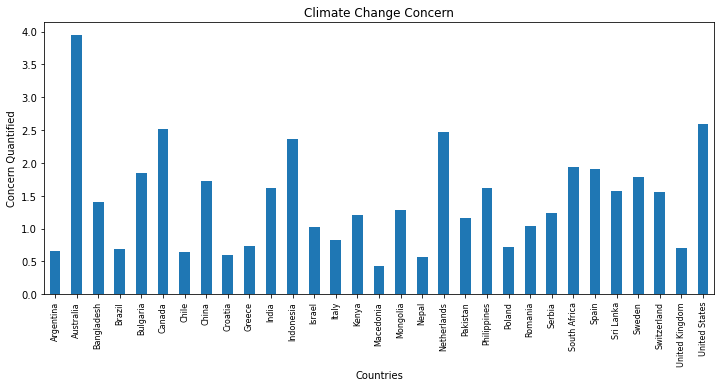

In [33]:
## Plotting

import matplotlib.pyplot as plt
ax = quantified_concern.plot(kind='bar',figsize=(12, 5))
ax.xaxis.set_tick_params(labelsize = 8)
ax.set_xlabel('Countries')
ax.set_ylabel('Concern Quantified')
plt.title("Climate Change Concern")

path = ".\\data\\climate-change-analysis\\"
plt.savefig( path + 'barplot.png', dpi=2000)
plt.show()

### Popular documentaries  

In [24]:
#Looking at the popular documentaries in South Korea, Ghana, Canada and Australia - top 4 countries.
df_pop_doc = constructDataFrame(dict_environment,listofAllCountries)
df_pop_doc.columns

Index(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas',
       ...
       'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States',
       'Uruguay', 'Vanuatu', 'Venezuela', 'Vietnam', 'Zambia', 'Zimbabwe'],
      dtype='object', length=158)

In [25]:
dict_environment[0].keys()

dict_keys(['BBC Climate Change The Facts', 'Living the Change: Inspiring Stories for a Sustainable Future', 'Chasing Coral', '2040 (2019)', 'This changes everything', 'Ice on Fire', 'Before the Flood', 'An Inconvenient Sequel', 'Racing Extinction', 'Catching the sun', 'Food Inc', 'Cowspirace-The Sustainability Secret', 'Chasing Ice', 'Honeyland', 'The True Cost'])

In [26]:
df_pop_doc[['Australia','United States','Netherlands','Canada','Indonesia']]

,Australia,United States,Netherlands,Canada,Indonesia
0,2,3,3,0,0
1,0,5,0,1,2
2,2,8,0,1,6
3,7,20,11,8,10
4,1,2,0,1,0
5,2,8,1,3,2
6,5,4,6,4,0
7,0,7,0,4,0
8,1,11,1,1,3
9,2,0,0,0,1


### Currently, Honeyland is a very popular documentary related to environment around the world

### <img src="./data/climate-change-analysis/Honeyland_poster.jpg" width="240" height="120">

## Generating Choropleths

In [36]:
import geopandas as gpd
import geoplot as gplot

In [54]:
#loading the climate concern data 
import pickle 
path = ".\\environment\\data\\"
path = "C:\\Users\deepa\\Desktop\\Dyaus\\torrent-analytics\\data\\climate-change-analysis\\"
with open(path+'quantified_concern_values.dat','rb') as f:
    quantified_concern_values = pickle.load(f)

In [55]:
#loading the world map
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
#Removing unpopulated areas and Antarctica
world_all = world[(world.name!="Antarctica")]

<AxesSubplot:>

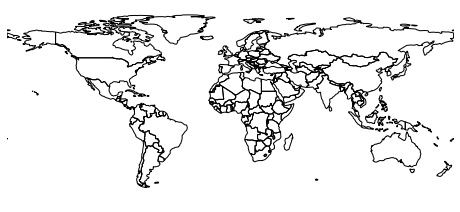

In [56]:
#Plotting the blank map
gplot.polyplot(world_all, figsize=(8, 4))

In [57]:
## Determining if the name of countries is same in world geodataframe and our Series

#list of countries in our Series
filtered_countries = quantified_concern_values.index.values.tolist()
world_countries = world['name'].tolist()

#Finding the countries whose names are missing
for x in filtered_countries:
    b=x in world_countries
    if b is False:
        print(x)

United States


In [58]:
## Only United States is missing, as it is United States of America in the world geodataframe
filtered_countries[filtered_countries.index("United States")]='United States of America'
quantified_concern_values.index = filtered_countries


### Plotting Choropleth

In [59]:
##Creating a Pandas Series with climate concern values

#collecting index of those elements in world_all which do not have any value in idx_0
idx_0 = []

#list containing values
climate_concern_list = []
i=0
for x in world['name']:
    
    if x in filtered_countries:
        climate_concern_list.append(quantified_concern_values[x])
    else:
        climate_concern_list.append(0)
        idx_0.append(i)
    i=i+1
        
#Creating Pandas Series from the list
import pandas as pd
clim_conc_value = pd.Series(climate_concern_list)

In [60]:
#Dropping rows from world pertaining to those which there is no information in climate change concern
world=world.drop(idx_0,axis=0)
clim_conc_value=clim_conc_value.drop(idx_0,axis=0)

#### Choropleth

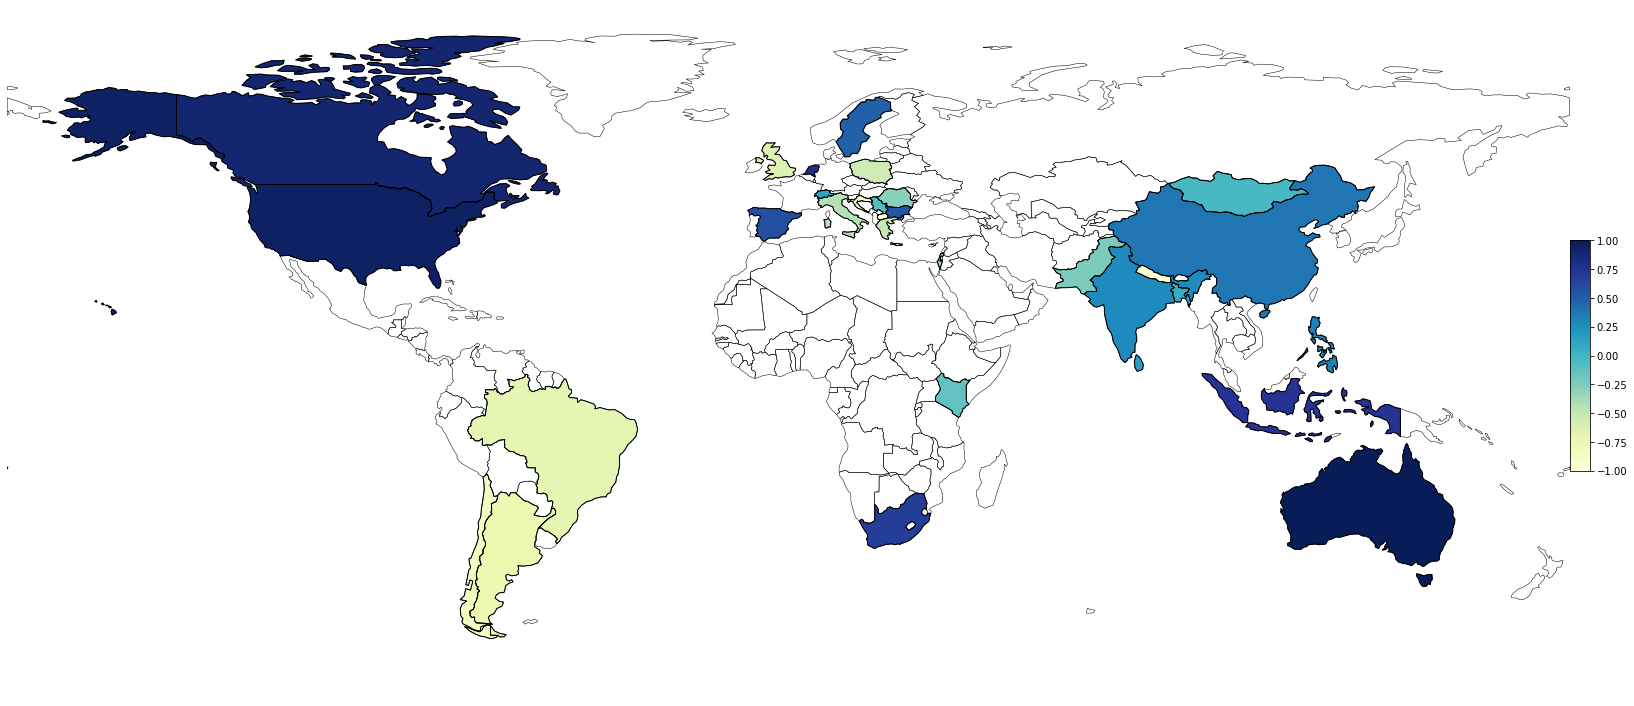

In [75]:
import matplotlib.pyplot as plt
import mapclassify

#k is the parameter which decides the number of classes
#we have 30 plus countries
scheme = mapclassify.Quantiles(clim_conc_value, k=40)


## Here two plots are superimposed because many countries are missing
## from the choropleth. So the world map with just the boundary is combined
## with it to give the full map. 

fig, ax = plt.subplots(figsize = (28,16))  
world_all.geometry.boundary.plot(color=None,edgecolor='k',
                                 linewidth = 0.5,ax=ax)
gplot.choropleth(
    world, hue=clim_conc_value, scheme=scheme,
    cmap='YlGnBu',ax=ax
)

## Adding a colorbar legend
## (https://stackoverflow.com/questions/36008648/colorbar-on-geopandas)
vmin, vmax = -1, 1
cax = fig.add_axes([0.9, 0.4, 0.01, 0.2])
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig.colorbar(sm, cax=cax)